<a href="https://colab.research.google.com/github/MMucahit/PyhtonDerinOrenmeFrancoisChollet/blob/main/BostonHousePrice(Do%C4%9Frusal_Ba%C4%9Flan%C4%B1m).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Şu anda GPU’da mı çalışıyorum?

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Hangi GPU’yu Kullanıyorum?

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11539469553135855351, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 665733965471786007
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

Veri Setini Yükleme

In [6]:
## Veri seti Bölgesel vergi oranı, suç oranı gibi verilerden olşuyor. Bu veriler ile 1970 ortalarında Boston banliyösündeli ev fiyatlarını tahmin etmeye çalışacağız.
## Veri seti 404'ü eğitim ve 102'si test örneği olmak üzere toplamda 506 örnek ile görece az veriye sahip bir settdir.
## Veri deki her nitelik farklı ölçeklerdedir. Bunun için normalizasyon edilmeli.
## Verideki fiyatlar 10 bin dolar cinsindedir.
from keras.datasets import boston_housing

In [7]:
(train_data, train_targets),(test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [8]:
print('train_data.shape: ', train_data.shape) ## 404 örnek(satır), 13 özellik(sütun)
print('test_data.shape: ', test_data.shape) ## 102 örnek, 13 özellik

train_data.shape:  (404, 13)
test_data.shape:  (102, 13)


Verilerin Hazırlanması

In [11]:
## Hepsi çok farklı aralıkta olan verilerle sinir ağılarını beslemek sorun çıkartabilir. Öğrenme zorlaşabilir.
## Bu yüzden her sütündan o sütünun ortalamasını çıkartıp standart sapmasına bölerek nitelikleri 0 civarına ortalar ve birim standart sapmaya sahip olabiliriz.

In [13]:
## Burada, test veri setini normalize etmek için eğitim veri setinde hesaplanan ortalam ve std yi kullandık. Kesinlikle iş akışınızda test veri seti üzerinde hesaplanmış bir değeri kullanmayın!

mean = train_data.mean(axis= 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

Ağı inşa etme

In [14]:
## Çok az veri olduğundan 64 birimli iki gizli katman kullanacağız. Genelde veri azaldıkça aşırı uyum olma olasılığı artar ve küçük bir ağ kurmak aşırı uydurmayı önlemenin bir yoludur.

from keras.models import Sequential
from keras.layers import Dense

In [38]:
## Loss fonksiyonu olarak mean squared error (ortalama karesel hata) tahminler ile doğru hedeflerin arasındaki farkın karesi
## Metrics olarak mean absolute error (ortalama mutlak hata) tahminler ile doğru hedefşer arasındaki farkın mutlak değeridir. Örneğin 0.5 lik bir MAE 500 dolarlık fark eder.
def build_model(): ## Aynı modeli birden fazla kez oluşturmak yerine bir fonksiyon ile yapabiliriz.
  model = Sequential()
  model.add(Dense(64, activation= 'relu', input_shape = (train_data.shape[1],)))
  model.add(Dense(64, activation= 'relu'))
  model.add(Dense(1, activation= 'linear'))

  model.compile(optimizer = 'rmsprop', loss ='mse', metrics = ['mae'])

  return model

K-FOLD Doğrulama ile Validataion

In [18]:
## Veri setimiz çok küçük olduğu için validation için veri ayırmak elimizde daha küçük bir verinin kalmasına neden olucaktır.
## Bunun sonucu olarak doğrulama değerleri hangi verinin doğrulama verisi olduğuna bağlı olarak değişiklik gösterecektir.
## Bu gibi durumlarda uygulanabilecek en iyi yaklaşım K-FOLD çapraz doğrulama kullanmak olacaktır.
## Eldeki veri K parçaya ayrılır. K tane aynı model oluşturulur ve K-1 parça veri ile eğitilip geri kalanı ile test edilir. Doğrulama skoru ise K tane doğrulama skorunun ortalamasıdır.

In [32]:
x = np.array([[1,2,3],[4,5,6]])
y = np.array([[4,5,6],[1,2,3]])

z = np.concatenate([x,y],axis = 0)

z

array([[1, 2, 3],
       [4, 5, 6],
       [4, 5, 6],
       [1, 2, 3]])

In [33]:
x = np.concatenate([train_data[:0],train_data[101:]],axis = 0)
print(x.shape)

y = np.concatenate([train_targets[:0],train_targets[101:]],axis = 0)
print(y.shape)

(303, 13)
(303,)


In [41]:
import numpy as np

K = 4
num_val_samples = len(train_data) // K
num_epochs = 100
all_scores = []

for i in range(K):
  print('Processing fold: ', i)

  # K.ıncı parçadaki doğrulama verisini hazırlama ## train_data = (404, 13)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] ## i = 0 ==> train_data[0 : 101] , i = 1 ==> train_data[101: 202], i = 2 ==> train_data[202: 303], i = 3 ==> train_data[303: 404]  
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] ## i = 0 ==> train_targets[0 : 101], i = 1 ==> train_targets[101: 202], i = 2 ==> train_targets[202: 303], i = 3 ==> train_data[303: 404]

  # Eğitim veri setini hazırlar: Veriler diğer parçalardan gelir.
  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples:]],axis = 0) ## i = 0 ==> partial_train_data[train_data[:0],train_data[:101]] 
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],axis = 0) ## i = 0 ==> partial_train_targets[train_data[:0],train_data[:101]]

  model = build_model()

  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0) ## verbose = 0 olduğu için eğitim sonuçları her epochda gösterilmez.

  ## Doğrulama veri setinde değerlendirir.
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)

  all_scores.append(val_mae)

Processing fold:  0
Processing fold:  1
Processing fold:  2
Processing fold:  3


In [45]:
## Bu durumda ortalama olarak hedeften 2500 dolar kadar uzakdayız.
print('all_scores: ', all_scores)
print('mean of all_scores: ', np.mean(all_scores))

all_scores:  [2.1650078296661377, 2.7146525382995605, 2.7321841716766357, 2.437485456466675]
mean of all_scores:  2.512332499027252


Her parçada doğrulama günlüğü kaydetmek. Epoch = 500 iken

In [64]:
K = 4
num_val_samples = len(train_data) // K
num_epochs = 500
all_mae_histories = []

for i in range(K):
  print('Processing fold: ', i)

  # K.ıncı parçadaki doğrulama verisini hazırlama ## train_data = (404, 13)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] ## i = 0 ==> train_data[0 : 101] , i = 1 ==> train_data[101: 202], i = 2 ==> train_data[202: 303], i = 3 ==> train_data[303: 404]  
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] ## i = 0 ==> train_targets[0 : 101], i = 1 ==> train_targets[101: 202], i = 2 ==> train_targets[202: 303], i = 3 ==> train_data[303: 404]

  # Eğitim veri setini hazırlar: Veriler diğer parçalardan gelir.
  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples:]],axis = 0) ## i = 0 ==> partial_train_data[train_data[:0],train_data[:101]] 
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],axis = 0) ## i = 0 ==> partial_train_targets[train_data[:0],train_data[:101]]

  model = build_model()

  history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1,validation_data=(val_data, val_targets), verbose = 0) ## verbose = 0 olduğu için eğitim sonuçları her epochda gösterilmez.

  mae_history = history.history['val_mae']

  all_mae_histories.append(mae_history)

Processing fold:  0
Processing fold:  1
Processing fold:  2
Processing fold:  3


In [65]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [66]:
## K-fold doğrulama skorlarının ortalamasını alamak
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# average_mae_history ## 500 tane

Doğrulama skorlarını çizdirme

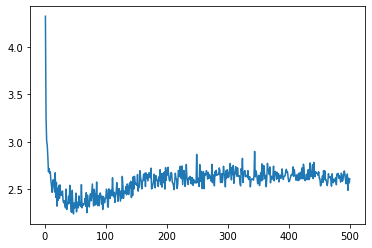

In [67]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel = 'Epoklar'
plt.ylabel = 'MAE-(Doğrulama)'
plt.show()

In [68]:
## Ölçekleme ve göreceli yüksek değşirlik olduğundan şekli okumak zor olabilir.
## Her noktayı önceki noktaların kayar ortalaması olarak göstererek yumuşak bir eğri çizdirelim.

In [78]:
def smooth_curve(points, factor = 0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points    

In [79]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

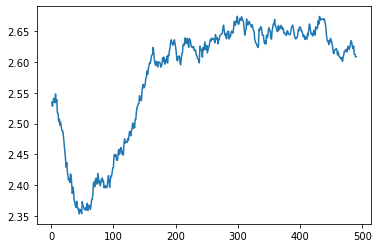

In [80]:
plt.plot(range(1, len(smooth_mae_history) +1), smooth_mae_history)
plt.xlabel = 'Epoklar'
plt.y_label = 'MAE-(Doğruluma)'
plt.show()

In [81]:
## 80 epokdan sonra MAE skoru ilerlemesini durduruyor. Bu noktadan sonra aşırı uydurma başlıyor.

Modelin Son Hali

In [101]:
## Ağın diğer parametrelerini (eopk sayısını gizli katmanların boyutunu nöron sayılarını vb.) yapılandırmayı bitirdikden sonra, son modeli tüm veri üzerinde eğiterek en iyi parametreler ile test edip performansını ölçebilirisiniz.
model = build_model()
model.fit(train_data, train_targets, epochs= 80, batch_size= 16, verbose= 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 17.6165 - mae: 2.7117


2.711672067642212